In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import csv
import pandas as pd
import numpy as np
import matplotlib.ticker as plticker
import cv2

In [2]:
df = pd.read_csv('../data.csv')
df.head()

,ImageLOC,ROI,Classes
0,./../ResizedJPEGImages/0.jpg,[[ 82 126 324 290] [ 92 1 348 157]],[cat chair]
1,./../ResizedJPEGImages/1.jpg,[[339 39 399 209] [111 130 263 385] [ 14 20...,[tvmonitor person chair]
2,./../ResizedJPEGImages/2.jpg,[[ 92 212 401 416] [ 52 79 158 389] [125 12...,[horse person person person horse]
3,./../ResizedJPEGImages/3.jpg,[[ 44 163 406 396]],[bus]
4,./../ResizedJPEGImages/4.jpg,[[201 147 234 250] [ 93 217 157 357] [ 47 13...,[person person car car]


In [3]:
def convert_numpy():
    a = df['ROI'][:]
    for i in range(df['ROI'].shape[0]):   
        b = a[i].replace('[', '')
        b = b.replace(']', '')
        b = np.fromstring(b, dtype=int, sep=' ')
        l = len(b)
        l = l/4
        b = np.split(b, l)
        b = np.asarray(b)
        df['ROI'][i] = b

    
convert_numpy()

In [4]:
def convert_class(df_):
    for i in range(df['Classes'].shape[0]):
        cls = []
        cls_ = df['Classes'][i]
        cls_ = cls_.replace('[', '')
        cls_ = cls_.replace(']', '')
        cls = cls_.split(' ')
        df['Classes'][i] = cls

convert_class(df)

In [5]:
img_loc = df['ImageLOC'][:]
roi = df['ROI'][:]
cls = df['Classes'][:]

['cat', 'chair']
82 126 324 290
92 1 348 157


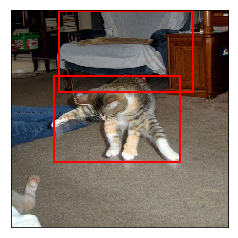

(416, 416, 3)
['tvmonitor', 'person', 'chair']
339 39 399 209
111 130 263 385
14 203 177 416


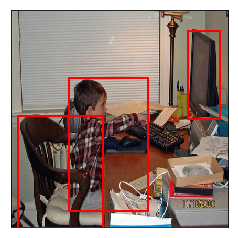

(416, 416, 3)


In [6]:
def plot_image(sample_image, sample_roi, sample_cls):    
    
    im = np.array(Image.open(sample_image), dtype=np.uint8)
    fix, ax = plt.subplots()
    ax.imshow(im)
    for i in range(sample_roi.shape[0]):
        x = sample_roi[i][0]
        y = sample_roi[i][1]
        x_max, y_max = sample_roi[i][2], sample_roi[i][3]
        print(x, y, x_max, y_max)
        rect = patches.Rectangle((x, y), (x_max - x), (y_max - y), linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()
    print(im.shape)
    
    
for j in range(0, 2):
    sample_img_loc = img_loc[j]
    sample_roi = roi[j]
    sample_cls = cls[j]
    print(sample_cls)
    plot_image(sample_img_loc, sample_roi, sample_cls)

339 39 399 209
111 130 263 385
14 203 177 416


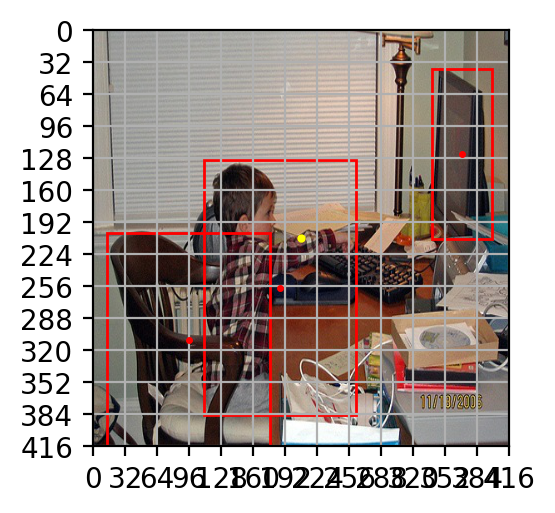

In [7]:
def plot_grid():
    image = Image.open(sample_img_loc)
    my_dpi=200.
    mid_img = (np.int(416/2), np.int(416/2))
    fig=plt.figure(figsize=(float(image.size[0])/my_dpi,float(image.size[1])/my_dpi),dpi=my_dpi)
    ax=fig.add_subplot(111)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

    myInterval=32
    loc = plticker.MultipleLocator(base=myInterval)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    
    for i in range(sample_roi.shape[0]):
        x = sample_roi[i][0]
        y = sample_roi[i][1]
        x_max, y_max = sample_roi[i][2], sample_roi[i][3]
        mid_ = (x+((x_max - x)/2), y+((y_max - y)/2))
        print(x, y, x_max, y_max)
        rect = patches.Rectangle((x, y), (x_max - x), (y_max - y), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.plot(mid_[0], mid_[1], color='red', marker='o', linestyle='dashed',
        linewidth=2, markersize=1.5)

    plt.plot(mid_img[0], mid_img[1], color='yellow', marker='o', linestyle='dashed',
        linewidth=2, markersize=2)
    ax.imshow(image)

plot_grid()


In [8]:
def get_grids(sample_roi):
    a_s = []
    b_s = []
    for i in range(sample_roi.shape[0]):

        x = sample_roi[i][0]
        y = sample_roi[i][1]
        x_max, y_max = sample_roi[i][2], sample_roi[i][3]
        mid_ = (x+((x_max - x)/2), y+((y_max - y)/2))

        for i in range(13):
            min_g = i*32
            max_g = min_g + 32

            if mid_[0] > min_g and mid_[0] < max_g:
                a_s.append(i+1)
        for i in range(13):
            min_g = i*32
            max_g = min_g + 32
            if mid_[1] > min_g and mid_[1] < max_g:
                b_s.append(i+1) 
    return a_s, b_s

a_s, b_s = get_grids(roi[1])
print(a_s, b_s)

[12, 6, 3] [4, 9, 10]


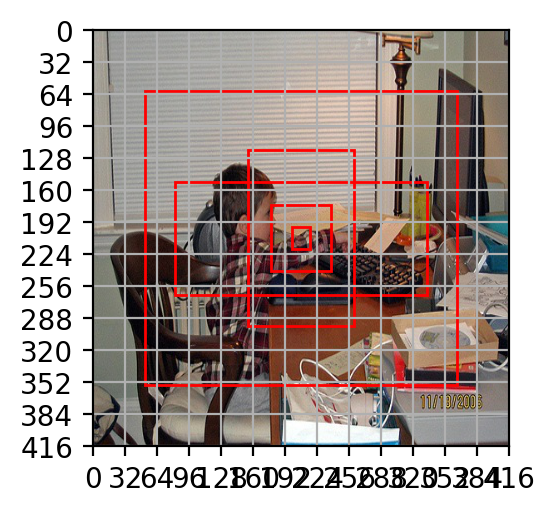

In [17]:
anchors = [[0.57273, 0.677385], [1.87446, 2.06253], [3.33843, 5.47434], [7.88282, 3.52778], [9.77052, 9.16828]]

def plot_anchors(sample_image, grid):
    
    image = Image.open(sample_image)
    my_dpi=200.
    fig=plt.figure(figsize=(float(image.size[0])/my_dpi,float(image.size[1])/my_dpi),dpi=my_dpi)
    ax=fig.add_subplot(111)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

    myInterval=32
    loc = plticker.MultipleLocator(base=myInterval)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    
    grid_x = grid[0]*32
    grid_y = grid[1]*32
    mid_grid = (grid_x + (32/2), grid_y + (32/2))
    
    for i in range(5):
        anc_w = anchors[i][0]*32
        anc_h = anchors[i][1]*32
        anc_x = mid_grid[0] - (anc_w/2)
        anc_y = mid_grid[1] - (anc_h/2)
        rect = patches.Rectangle((anc_x, anc_y), anc_w, anc_h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.imshow(image)
    
plot_anchors(img_loc[1], [6, 6])

    
    

In [10]:
def calc_iou(bb1, bb2):
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [11]:
sample_iou = calc_iou(sample_roi[2], sample_roi[1])
print(sample_iou)

0.19542193372053296


In [30]:
def redef_anchors(anchors_, grid):
    anchors = []
    grid_x = grid[0]*32
    grid_y = grid[1]*32
    mid_grid = (grid_x + (32/2), grid_y + (32/2))
    for i in range(5):
        anc_w = anchors_[i][0]*32
        anc_h = anchors_[i][1]*32
        anc_x = mid_grid[0] - (anc_w/2)
        anc_y = mid_grid[1] - (anc_h/2)
        anc_x_max = anc_x + anc_w
        anc_y_max = anc_y + anc_h
        anc = [int(anc_x), int(anc_y), int(anc_x_max), int(anc_y_max)]
        for i in range(len(anc)):
            if anc[i] < 0:
                anc[i] = 0
            elif anc[i] > 416:
                anc[i] = 416
        anchors.append(anc)
    return anchors

[[339, 39, 399, 209], [111, 130, 263, 385], [14, 203, 177, 416]] 

[[390, 133, 409, 154], [370, 110, 416, 177], [346, 56, 416, 231], [273, 87, 416, 200], [243, 0, 416, 290]]
[0.018155619596541786, 0.17135549872122763, 0.5654417404644028, 0.34628939169518363, 0.20330875024915288] 



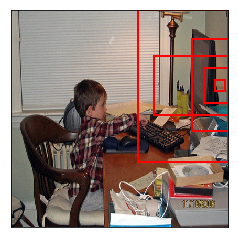

[[198, 293, 217, 314], [178, 270, 237, 337], [154, 216, 261, 391], [81, 247, 334, 360], [51, 157, 364, 416]]
[0.010294117647058823, 0.10198658410732714, 0.4589360946144866, 0.34233551910390053, 0.4068990618872621] 



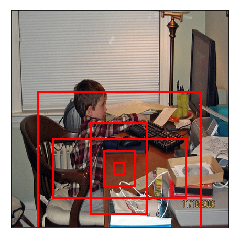

[[102, 325, 121, 346], [82, 302, 141, 369], [58, 248, 165, 416], [0, 279, 238, 392], [0, 189, 268, 416]]
[0.011492266482329561, 0.11385696592643797, 0.5177568478354792, 0.42642496643052274, 0.5706982707607338] 



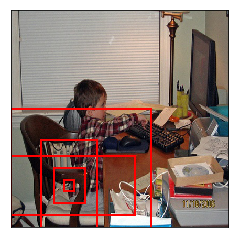

[2, 2, 4]
[0.5654417404644028, 0.4589360946144866, 0.5706982707607338]


In [47]:
anchors_ = [[0.57273, 0.677385], [1.87446, 2.06253], [3.33843, 5.47434], [7.88282, 3.52778], [9.77052, 9.16828]]
def get_output_vector(img_loc, roi, cls, anchors=anchors):
    output_vector = np.zeros((13, 13, 125), dtype=np.float32)
    grid_a, grid_b = get_grids(roi)
    out_anchor = []
    roi = np.ndarray.tolist(roi)
    print(roi, '\n')
    selected_anchor_pos = []
    selected_anchor_val = []
    
    for i in range(len(grid_a)):
        ious = []
        anchors = redef_anchors(anchors_, [grid_a[i], grid_b[i]])
        print(anchors)
        for j in range(5):
            iou = calc_iou(anchors[j], roi[i])
            ious.append(iou)
        print(ious, '\n')
        sel_anc_pos = np.argmax(ious)
        sel_anc_val = ious[sel_anc_pos]
        selected_anchor_pos.append(sel_anc_pos)
        selected_anchor_val.append(sel_anc_val)
        
        im = np.array(Image.open(img_loc), dtype=np.uint8)
        fix, ax = plt.subplots()
        ax.imshow(im)
        for j in range(5):
            x = anchors[j]
        
            x = anchors[j][0]
            y = anchors[j][1]
            x_max, y_max = anchors[j][2], anchors[j][3]
            rect = patches.Rectangle((x, y), (x_max - x), (y_max - y), linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.show()
    print(selected_anchor_pos)
    print(selected_anchor_val)
        
        

get_output_vector(sample_img_loc, sample_roi, sample_cls)